In [1]:
# DATA: https://www.floydhub.com/fastai/datasets/cats-vs-dogs

In [2]:
import tensorflow as tf
import os

In [7]:
!ls ../../big_data/fastai-datasets-cats-vs-dogs-2/

models/ sample/ test1/  train/  valid/


## 写入TFRecord：

1. 读取该数据元素到内存；

2. 将该元素转换为 `tf.train.Example` 对象（每一个 `tf.train.Example` 由若干个 `tf.train.Feature` 的字典组成，因此需要先建立 Feature 的字典）；

3. 将该 `tf.train.Example` 对象序列化为字符串，并通过一个预先定义的 `tf.io.TFRecordWriter` 写入 TFRecord 文件。

## 读取TFRecord：

1. 通过 `tf.data.TFRecordDataset` 读入原始的 TFRecord 文件（此时文件中的 `tf.train.Example` 对象尚未被反序列化），获得一个 `tf.data.Dataset` 数据集对象；

2. 通过 `Dataset.map` 方法，对该数据集对象中的每一个序列化的 `tf.train.Example` 字符串执行 `tf.io.parse_single_example` 函数，从而实现反序列化。



TFRecord 可以理解为一系列序列化的 `tf.train.Example` 元素所组成的列表文件，而每一个 `tf.train.Example` 又由若干个 `tf.train.Feature` 的字典组成。
```python
# dataset.tfrecords
[
    {   # example 1 (tf.train.Example)
        'feature_1': tf.train.Feature,
        ...
        'feature_k': tf.train.Feature
    },
    ...
    {   # example N (tf.train.Example)
        'feature_1': tf.train.Feature,
        ...
        'feature_k': tf.train.Feature
    }
]
```
`tf.Example` 是 `{"string": tf.train.Feature}` 的映射。

`tf.train.Feature` 可以接受下面的三种类型传入，其他类型可以转换为下面这三种：

---
1. `tf.train.BytesList` 
  - `string`
  - `byte`
---
2. `tf.train.FloatList` 
  - `float` (`float32`)
  - `double` (`float64`)
---
3. `tf.train.Int64List`
  - `bool`
  - `enum`
  - `int32`
  - `uint32`
  - `int64`
  - `uint64`

In [8]:
data_dir = '../../big_data/fastai-datasets-cats-vs-dogs-2'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
tfrecord_file = data_dir + '/train/train.tfrecords'

In [10]:
train_cat_filenames = [train_cats_dir + filename for filename in os.listdir(train_cats_dir)]
train_dog_filenames = [train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)]
train_filenames = train_cat_filenames + train_dog_filenames
# 将 cat 类的标签设为0，dog 类的标签设为1
train_labels = [0] * len(train_cat_filenames) + [1] * len(train_dog_filenames)  

In [11]:
with tf.io.TFRecordWriter(tfrecord_file) as writer:
    for filename, label in zip(train_filenames, train_labels):
        image = open(filename, 'rb').read()     # 读取数据集图片到内存，image 为一个 Byte 类型的字符串
        feature = {                             # 建立 tf.train.Feature 字典
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),  # 图片是一个 Bytes 对象
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))   # 标签是一个 Int 对象
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature)) # 通过字典建立 Example
        writer.write(example.SerializeToString())   # 将Example序列化并写入 TFRecord 文件

In [12]:
# 读取 TFRecord 文件
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)   

feature_description = { # 定义Feature结构，告诉解码器每个Feature的类型是什么
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_example(example_string): # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])    # 解码JPEG图片
    return feature_dict['image'], feature_dict['label']

dataset = raw_dataset.map(_parse_example)

In [14]:
dataset

<MapDataset shapes: ((None, None, None), ()), types: (tf.uint8, tf.int64)>

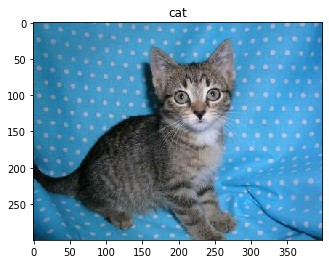

In [17]:
import matplotlib.pyplot as plt 
%matplotlib inline
for image, label in dataset:
    plt.title('cat' if label == 0 else 'dog')
    plt.imshow(image.numpy())
    plt.show()
    break